In [1]:
using_colab = 'google.colab' in str(get_ipython())
if using_colab:
  !git clone https://github.com/mahynski/chemometrics.git
  !cd chemometrics; pip install -r requirements.txt
else:
  import sys
  sys.path.append('../../')

import chemometrics

import matplotlib.pyplot as plt
%matplotlib notebook

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

Cloning into 'chemometrics'...
remote: Enumerating objects: 638, done.
remote: Counting objects: 100% (638/638), done.
remote: Compressing objects: 100% (464/464), done.
remote: Total 638 (delta 377), reused 371 (delta 161), pack-reused 0
Receiving objects: 100% (638/638), 8.34 MiB | 13.36 MiB/s, done.
Resolving deltas: 100% (377/377), done.
     |████████████████████████████████| 86 kB 2.2 MB/s 
     |████████████████████████████████| 1.1 MB 19.3 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82708 sha256=3a1c256c5378826fe997aef25c754339f86eae83e71e205760a7e8ecae7fb9da
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.6-py3-none-any.whl size=53943 sha256=03bfa6ec6039fffc93d0b5b5deba26791057e2ae53b34c4d0d1b33f9e22ca6b7
  Stored in directory: /root/.cache/pip/wheels/03/f1/56/f80d72741e400345b5a5b50ec3d929aca581bf45e0225d5c50
Successful

In [2]:
import numpy as np
import sklearn.decomposition
import sklearn.manifold

from chemometrics.manifold.elliptic import EllipticManifold

In [3]:
!cd chemometrics; git pull

Already up to date.


Overview
--------
This is a set of simple examples using various manifold methods to perform dimensionality reduction, followed by fitting with an elliptical boundary.

In [4]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.144+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

numpy     : 1.19.5
matplotlib: 3.2.2
watermark : 2.3.0
IPython   : 5.5.0
sklearn   : 0.0



# Load Data

In [5]:
import sklearn.datasets
data = sklearn.datasets.load_iris()

X = data.data
y = data.target

X_0 = X[y == 0]
y_0 = y[y == 0]

X_1 = X[y == 1]
y_1 = y[y == 1]

X_2 = X[y == 2]
y_2 = y[y == 2]

import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X_0, 
                                                                            y_0,
                                                                            test_size=0.2, 
                                                                            shuffle=True, 
                                                                            random_state=0)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler(with_mean=False, with_std=False)

ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)
X_1_scaled = ss.transform(X_1)
X_2_scaled = ss.transform(X_2)

# Kernel PCA Example

See [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html?highlight=kernel%20pca#sklearn.decomposition.KernelPCA) for details on hyperparameters.

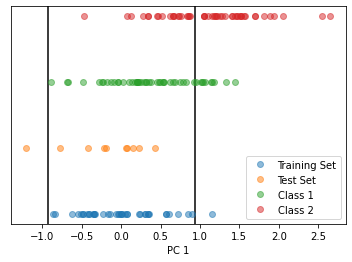

In [6]:
model = sklearn.decomposition.KernelPCA
kwargs = {"n_components":1, "kernel":"linear"}

m = EllipticManifold(0.05, model, kwargs)
_ = m.fit(X_train)

_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"])

In [7]:
m.score(X_test_scaled, [1]*len(X_test_scaled))

0.9

In [8]:
m.score(X_1_scaled, [-1]*len(X_1_scaled)) # 1D is not enough to distinguish class 0 from 1

0.2

In [9]:
# Try a 2D model instead
kwargs = {"n_components":2, "kernel":"linear"}

m = EllipticManifold(0.05, model, kwargs)

In [10]:
_ = m.fit(X_train_scaled)

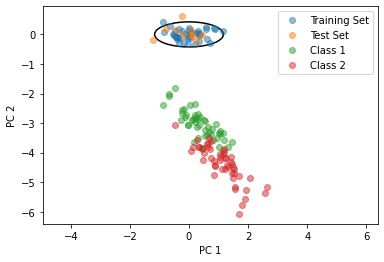

In [11]:
_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"])

In [12]:
m.predict(X_test_scaled, y_test) # 1 = inliner, -1 = outlier

array([ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.])

In [13]:
m.score(X_test_scaled, [1]*len(X_test_scaled)) # Score the test set (all same class as training)

0.8

In [14]:
m.score(X_1_scaled, [-1]*len(X_1_scaled)) # Score a different class (different from training)

1.0

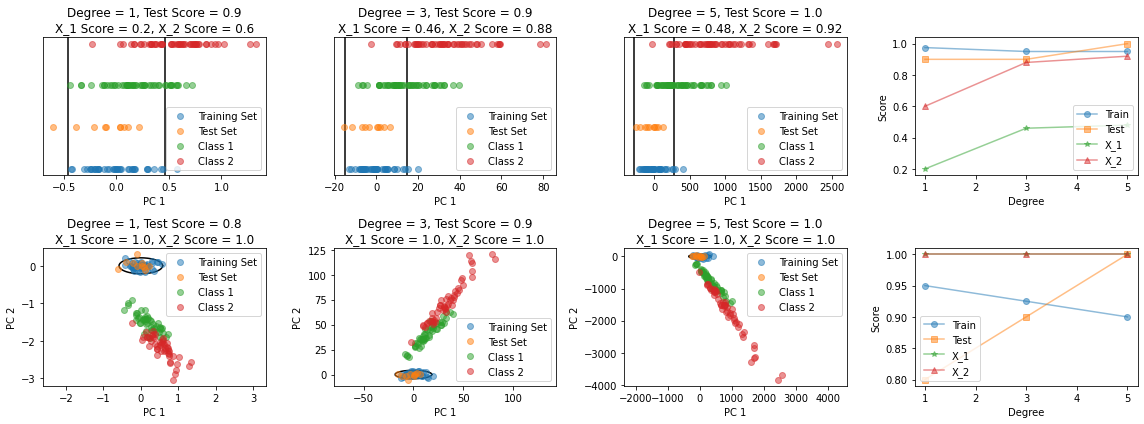

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for degree in [1, 3, 5]:
        model = sklearn.decomposition.KernelPCA
        kwargs = {"n_components":dims, 
                  "kernel":"poly", 
                  "degree":degree 
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [-1]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [-1]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Degree = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(degree, test_score,x1_score, x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([1, 3, 5], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([1, 3, 5], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([1, 3, 5], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([1, 3, 5], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Degree')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()

# Isomap Example

See [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html?highlight=isomap#sklearn.manifold.Isomap) for details on hyperparameters.

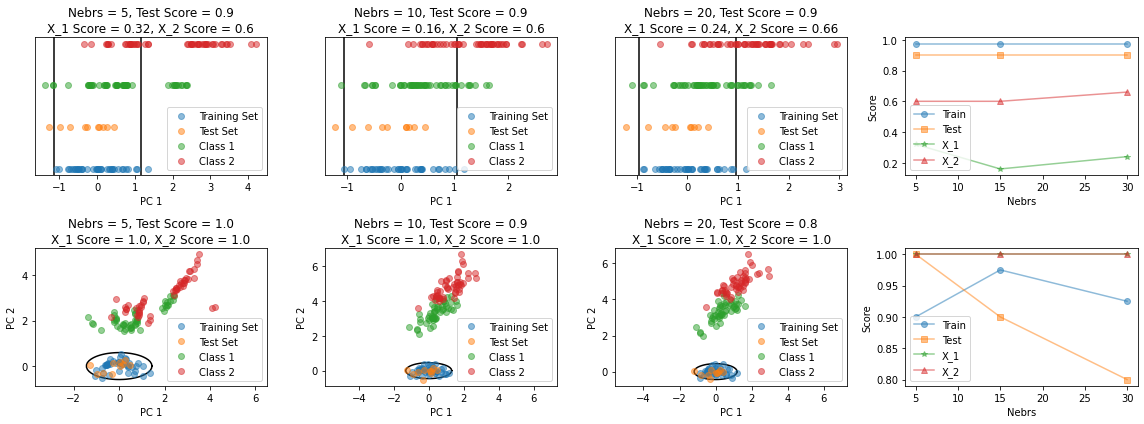

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for nebrs in [5, 10, 20]:
        model = sklearn.manifold.Isomap
        kwargs = {"n_neighbors":nebrs, 
                  "n_components":dims, 
                  "metric":'minkowski', 
                  "p":2, 
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [-1]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [-1]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(nebrs, test_score,x1_score, x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([5, 15, 30], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([5, 15, 30], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([5, 15, 30], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([5, 15, 30], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Nebrs')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()

# LLL Example

See [sklearn's documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html?highlight=locally%20linear#sklearn.manifold.LocallyLinearEmbedding) for details on hyperparameters.

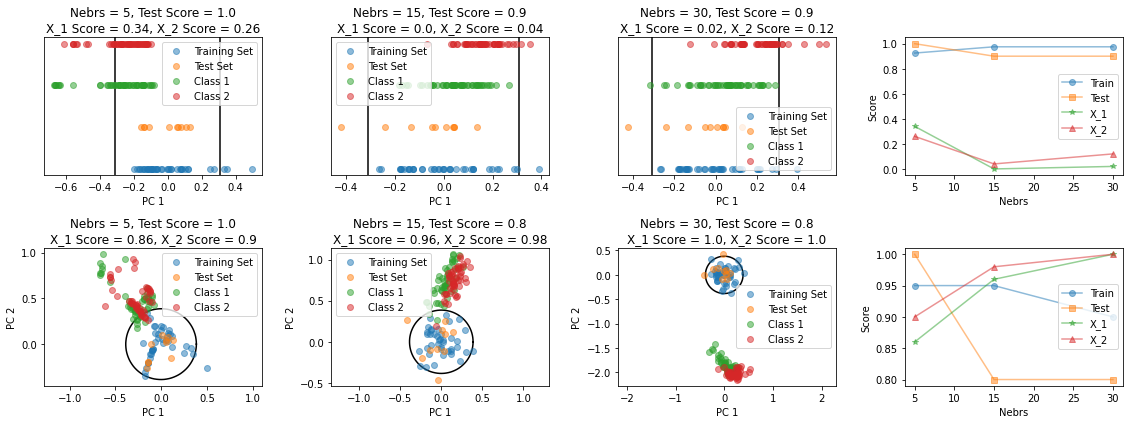

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for nebrs in [5, 15, 30]:
        model = sklearn.manifold.LocallyLinearEmbedding
        kwargs = {"n_neighbors":nebrs, 
                  "n_components":dims,
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [-1]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [-1]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(nebrs, test_score,x1_score, x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([5, 15, 30], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([5, 15, 30], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([5, 15, 30], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([5, 15, 30], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Nebrs')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()

# UMAP Example

UMAP has a lot of parameters that should be understood before using it.  See the [documentation](https://umap-learn.readthedocs.io/en/latest/parameters.html) for explanation. Briefly, there are 4 that matter the most:
* n_neighbors
* n_components
* metric
* min_dist

**IMPORTANTLY** you should always set random_state to ensure reproducibility between runs since UMAP is stochastic.

In [19]:
import umap

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


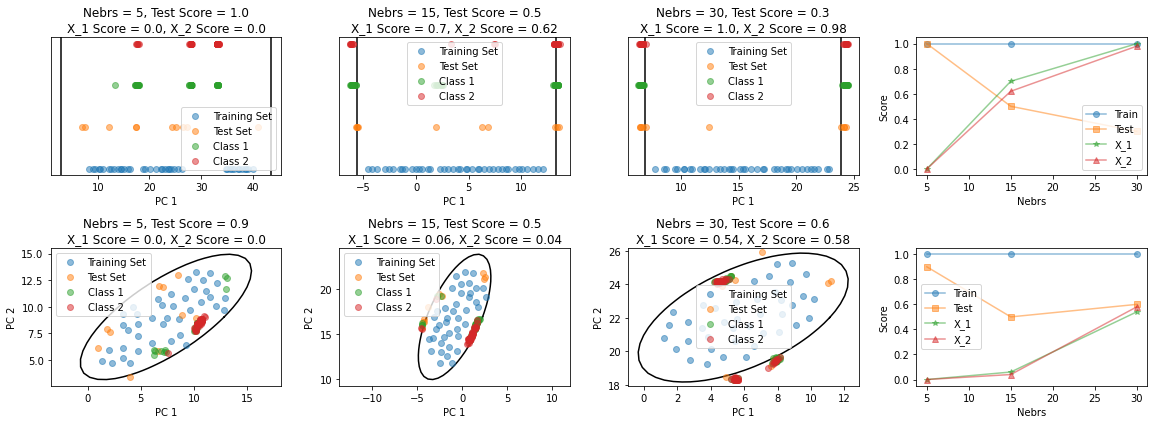

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16,6))
ax = axes.flatten()

idx = 0
for dims in [1, 2]:
    scores = []
    for nebrs in [5, 15, 30]:
        model = umap.UMAP
        kwargs = {"n_neighbors":nebrs, # Less focuses on finer detail, more is "bigger picture"
                  "n_components":dims, # Final dimensionality
                  "random_state":0, # Always set this for reproducibility
                  "metric":"euclidean", # How to compute distance between points in the ambient input space
                  "min_dist":1.0 # Closest points are allowed to come in the embedding (only controls training data, test can end up closer)
                 }
        m = EllipticManifold(0.05, model, kwargs)
        _ = m.fit(X_train_scaled)
        train_score = m.score(X_train_scaled, [1]*len(X_train_scaled))
        test_score = m.score(X_test_scaled, [1]*len(X_test_scaled))
        x1_score = m.score(X_1_scaled, [-1]*len(X_1_scaled))
        x2_score = m.score(X_2_scaled, [-1]*len(X_2_scaled))
        scores.append([train_score, test_score, x1_score, x2_score])
        
        ax_ = m.visualize([X_train_scaled, X_test_scaled, X_1_scaled, X_2_scaled], ["Training Set", "Test Set", "Class 1", "Class 2"], ax[idx])
        ax_.set_title('Nebrs = {}, Test Score = {}\nX_1 Score = {}, X_2 Score = {}'.format(nebrs, test_score,x1_score, x2_score))
        idx += 1
    scores = np.array(scores)
    ax[idx].plot([5, 15, 30], scores[:, 0], '-o', alpha=0.5, label='Train')
    ax[idx].plot([5, 15, 30], scores[:, 1], '-s', alpha=0.5, label='Test')
    ax[idx].plot([5, 15, 30], scores[:, 2], '-*', alpha=0.5, label='X_1')
    ax[idx].plot([5, 15, 30], scores[:, 3], '-^', alpha=0.5, label='X_2')
    ax[idx].set_xlabel('Nebrs')
    ax[idx].set_ylabel('Score')
    ax[idx].legend(loc='best')
    idx += 1

plt.tight_layout()